In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as spp

In [2]:
def is_Spain(x):
    if type(x)==str:
        if 'Spain' in x:
            return True
        else:
            return False
    return False

def is_Argentina(x):
    if type(x)==str:
        if 'Argentina' in x:
            return True
        else:
            return False
    return False

def is_Burgundy_France(x, y):
    if type(x)==str:
        if 'Burgundy' in x and 'France' in y:
            return True
        else:
            return False
    return False

data = pd.read_csv("winemag-data-130k-v2.csv")

df = data[['country', 'points', 'price', 'province']]
df.to_csv ('new_wine.csv', index=False)
data_new = pd.read_csv ('new_wine.csv')

data_new = data_new.groupby(data.apply(lambda x: is_Spain(x['country']) or is_Argentina(x['country']) or is_Burgundy_France(x['province'], x['country']), axis=1))
data_new = data_new.get_group(True)
data_new = data_new.dropna(axis=0)

# data_new = data_new.sort_values(by='country')
# data_new = data_new[:11000]

Закончили предварительную обработку таблиц. Посчитаем соотношение цена/качество для каждой записи. И построим "ящики с усами" чтобы прикинуть совпадают ли дисперсии

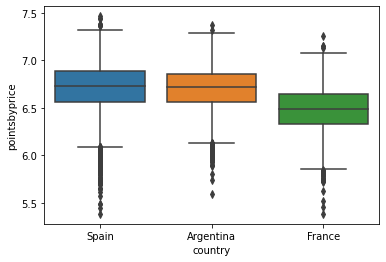

In [3]:
data_new['pointsbyprice']= data_new.apply(lambda x: x['points']/(10+np.log( x['price'])), axis=1)

sns.boxplot( y=data_new['pointsbyprice'], x=data_new['country']);
plt.show()

По графикам видно, что все плохо и дисперсии не совпадают, теперь проверим это статистически с помощью Теста Левена. Также проверим с помощью Теста Шапиро нормальность выборок.

In [4]:
print (stats.levene(data_new['pointsbyprice'][data['country'] == 'Spain'],
                    data_new['pointsbyprice'][data_new['country'] == 'Argentina'],
                    data_new['pointsbyprice'][(data_new['province'] == 'Burgundy')]))

print (stats.shapiro(data_new['pointsbyprice'][data_new['country'] == 'Spain']))
print (stats.shapiro(data_new['pointsbyprice'][data_new['country'] == 'Argentina']))
print (stats.shapiro(data_new['pointsbyprice'][data_new['province'] == 'Burgundy']))

LeveneResult(statistic=14.702413710172433, pvalue=4.186024500997588e-07)
ShapiroResult(statistic=0.971365749835968, pvalue=2.7515436822282986e-34)
ShapiroResult(statistic=0.9820742011070251, pvalue=2.043422475825461e-21)
ShapiroResult(statistic=0.9886605739593506, pvalue=4.765556862567884e-15)


/home/pam/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Нормальности тоже нет. Нельзя использовать ни ANOVA ни Крускала-Уоллиса (

In [5]:
#print (stats.kruskal(data_new['pointsbyprice'][data_new['country'] == 'Portugal'], data_new['pointsbyprice'][data_new['country'] == 'Greece'], data_new['pointsbyprice'][data_new['country'] == 'Canada']))

KruskalResult(statistic=nan, pvalue=nan)


In [6]:
#Данна, Тьюки:
print(pairwise_tukeyhsd(endog=data_new['pointsbyprice'], groups=data_new['country'], alpha=0.05))
print ('\n')
print (spp.posthoc_dunn([data_new['pointsbyprice'][data_new['country'] == 'Portugal'], data_new['pointsbyprice'][data_new['country'] == 'Greece'], data_new['pointsbyprice'][data_new['country'] == 'Canada']], p_adjust='fdr_bh'))

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1  group2 meandiff p-adj   lower   upper  reject
-------------------------------------------------------
Argentina France  -0.2257  0.001 -0.2397 -0.2118   True
Argentina  Spain   0.0043 0.6543 -0.0075  0.0161  False
   France  Spain     0.23  0.001  0.2175  0.2425   True
-------------------------------------------------------




ZeroDivisionError: float division by zero

In [7]:
data_new_crosstab = pd.crosstab(data_new['points'], data_new['country'], margins = False)
print(data_new_crosstab) 

country  Argentina  France  Spain
points                           
80              76       0     78
81              94       1     92
82             147       6    212
83             280      24    347
84             406     100    488
85             416     191    629
86             416     208    799
87             465     315    913
88             389     383    833
89             299     290    599
90             247     317    540
91             207     309    394
92             180     313    354
93              80     290    164
94              43     192     80
95               8     111     29
96               2      34     16
97               1      16      5
98               0       5      1
99               0       1      0


In [8]:
sp.stats.chi2_contingency(data_new_crosstab)

(1729.092344793215,
 0.0,
 38,
 array([[4.30535169e+01, 3.56028284e+01, 7.53436546e+01],
        [5.22792706e+01, 4.32320060e+01, 9.14887235e+01],
        [1.02042426e+02, 8.43833271e+01, 1.78574246e+02],
        [1.81998958e+02, 1.50502866e+02, 3.18498176e+02],
        [2.77890882e+02, 2.29800074e+02, 4.86309044e+02],
        [3.45546409e+02, 2.85747376e+02, 6.04706215e+02],
        [3.97825679e+02, 3.28979382e+02, 6.96194939e+02],
        [4.73309118e+02, 3.91399926e+02, 8.28290956e+02],
        [4.48707108e+02, 3.71055452e+02, 7.85237440e+02],
        [3.32127131e+02, 2.74650391e+02, 5.81222479e+02],
        [3.08643394e+02, 2.55230666e+02, 5.40125940e+02],
        [2.54407146e+02, 2.10380350e+02, 4.45212505e+02],
        [2.36794343e+02, 1.95815556e+02, 4.14390100e+02],
        [1.49289468e+02, 1.23453964e+02, 2.61256569e+02],
        [8.80640119e+01, 7.28239672e+01, 1.54112021e+02],
        [4.13761072e+01, 3.42157052e+01, 7.24081876e+01],
        [1.45375512e+01, 1.20217343e+01, 